# BARRA LINEAR ESTÁTICA 1D

Exemplo retirado do capítulo 5 do livro do Kollmannsberger  
**Notebook por:** Paulo de Souza Silva  
**Data:** Maio/Junho de 2025

Para uma barra linear estática, podemos definir o problema de mecânica da estruturas conforme o seguinte sistema.

$$\begin{aligned}
\frac{d}{dx}\left(EA \frac{du}{dx} \right)+ p & = 0 & \hspace{1.5cm} \text{em} \ \Omega\\
EA \frac{du}{dx} & = F & \hspace{1.5cm} \text{em} \ \Gamma_N\\
u & = g  &\hspace{1.5cm} \text{em} \ \Gamma_D
\end{aligned}
$$
Em que se define
* As condições de Neumann e Dirichlet ($\Gamma_N$ e $\Gamma_D$)
* $F$ são as cargas concentradas na fronteira de $\Gamma_N$
* $g$ são os deslocamentos em $\Gamma_D$
* $E$ e $A$ são o **Módulo de Elasticidade** e a **Área da barra** e podem variar com $x$

## Exemplo
Seja uma barra definida no domínio dado por $\Omega = [0 \ 1]$ e parâmetros materiais aplicados como $EA = 1$.

![Barra](https://drive.google.com/uc?export=view&id=1jmt07CK7tYLt66ZMDBt93HYL4tVx7ZTO)

O carregamento e as condições no contorno são respectivamente:

$$p(x) = 4\pi^2 \sin(2\pi x)\hspace{1cm}   \ u(0) = u(1) = 0$$

e portanto não tem carga concentrada na fronteira ($\Gamma_N = \emptyset$).
Nesse caso então, a solução analítica é da forma:
$$u(x) = \sin(2\pi x)$$

### Parâmetros para resolução

Nossa aproximação utilizando a técnica de PINNs será a seguinte:
* **Não iremos** utilizar a solução analítica como dados de treino.
* Serão considerados **20 pontos de colocação**
* A função de ativação será a **Tangente Hiperbólica** (`Tahn`)
* A rede terá somente **1 camada escondida** com **40 neurônios**
* Os otimizadores a serem usados podem ser o **Adam** ou **LBFGS (Limited Memory Broyden–Fletcher–Goldfarb–Shanno)**

Dessa forma, a nossa *Loss Function* pode ser escrita da seguinte forma:
$$\mathcal{L} = \mathcal{L}_{EDO} + \mathcal{L}_{ub}$$

ou de forma extensa, considerando o **Erro Quadrado Médio** (MSE - *Mean Square Error*)

$$\mathcal{L} = \sum_{i=1}^{20}\left[\frac{d}{dx}\left(EA \frac{d}{dx}u_{NN}(x_f^i) \right) + 4\pi^2 \sin(2\pi x_f^i)\right]^2+ (u_{nn}(0)-u_b(0))^2+(u_{nn}(1)-u_b(1))^2$$

### Definições Iniciais
**bibliotecas importantes**

In [1]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
from matplotlib import rc
import numpy as np
dtype = torch.float
device = torch.device("cpu")

**funcao que define os pontos de colocacao no caso 1D**

Definimos uma função **`generate_grid_1d`** que deve:
* Receber o tamanho da barra ***length***
* Receber a quantidade pontos de colocação ***samples***
* Receber a coordenada inicial
* Retornar os pontos de colocação no eixo

**`torch.linspace`** gera os pontos no intervalo  
**`requires_grad = True`** informa que esses pontos serão derivados futuramente  
**`view`** define o novo formato do tensor

In [2]:
def generate_grid_1d(length, samples=20, initial_coordinate=0.0):
    """Generate an evenly space grid of a given length and a given number of samples."""
    # Generate the grid
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)
    # Reshape on a column tensor and return
    return x.view(samples, 1)

**funcao para calcular derivadas de ordem n com o Pytorch**

Definimos uma função **`get_derivative`** que recebe:
* A função y
* A variável x
* A ordem n da derivada

**`grad`** comando do PyTorch para fazer a derivada  
**`device`** tipo de ambiente usado (**CPU**, GPU ou TPU)  
**`torch.ones`** Faz o papel de informar ao autograd como deve ser feita a relação entre as derivadas de y com relação a x  

> Obs: Lembrar que Y e X não são escalares mas sim tensores

**`create_graph`** informamos ao sistema que queremos a criação de um grafo para fazer operações;  
**`retain_graph`** garante que o grafo não será apagado após o uso da operação, permitindo que a derivada seja utilizada para operações futuras.

In [3]:
def get_derivative(y, x, n):
    """Calcula a n-esima deriva de y = f(x) com respeito a x."""
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)

**criacao de uma modelo de rede generico**

Como estamos criando nossa rede manualmente, precisamos desenvolver seu esqueleto, para isso vamos criar uma função denominada **`build_model`**, ela vai:

* Receber a dimensão da variavel de entrada
* Receber a dimensão e formato da camada escondida
* Receber a dimensão da camada de saída
* Retornar a arquitetura da rede

Aqui devemos usar a classe `torch.nn` que tem diversas funções específicas para interligar os neurônios da rede.

**`nn.Linear`**: Faz uma operação linear dentro da rede $z=Wx+b$  
**`nn.Tahn`**: Faz uma operação com a Tangente Hiperbólica $f(z) = \frac{e^z -e^{-z}}{e^z + e^{-z}}$  
**`nn.Sequential`**: Container que empacota uma sequência de módulos (camadas) e os executa em ordem

In [4]:
def build_model(input_dimension, hidden_dimension, output_dimension):
    """Construção da rede neural de dimensões fornecidas."""

    modules=[]
    modules.append(torch.nn.Linear(input_dimension, hidden_dimension[0]))
    modules.append(torch.nn.Tanh())
    for i in range(len(hidden_dimension)-1):
        modules.append(torch.nn.Linear(hidden_dimension[i], hidden_dimension[i+1]))
        modules.append(torch.nn.Tanh())

    modules.append(torch.nn.Linear(hidden_dimension[-1], output_dimension))

    model = torch.nn.Sequential(*modules)

    return model

## Criacao da **Classe** PINN-Bar-Model

Como nesse caso o código não pode ser quebrado, primeiro segue a explicação das **funções** que são definidas e depois o código completo.



### Definicoes padroes para o modelo da barra e da rede

Definimos no começo da classe um construtor **`__init__`** e quais parâmetros ela recebe ou receberá.

```python
def __init__(self, E, A, L, u0, dist_load):
  """Construct a PhysicsInformedBar model"""
  self.E = E                                      # Modulo de Elasticidade
  self.A = A                                      # Area da barra
  self.L = L                                      # Comprimento da barra
  self.x = generate_grid_1d(L)                    # Pontos de colocacao
  self.u0 = u0                                    # Condicoes de contorno
  self.dist_load = dist_load                      # Carregamento na barra
  self.model = build_model(1,[40],1)              # Definindo a estrutura da rede
  self.EDP_loss_history = None                    # Historico da Funcao de Perda da EDO
  self.ICBC_loss_history = None                   # Historico da Funcao de Perda das Condicoes de Contorno
  self.total_loss_history = None                  # Historico da Funcao de Perda Total
  self.optimizer = None                           # Otimizador
```

### Deslocamentos
Temos que definir que o deslocamento ($u_{NN}$) nada mais é que o modelo advindo da rede para nossos pontos ($x$).

```python
def get_displacements(self, x):
    """Get displacements."""
    u = self.model(x)   # predict
    return u
```



### Funcoes de Custo
Apos obtenção do deslocamento via rede ($u_{NN}$), podemos:
* calcular a nossa EDO
* calcular o **MSE** referente a cada uma das parcelas de custo ($\mathcal{L}_{EDO}$ e $\mathcal{L}_{ub}$)

Relembrando que:
$$\mathcal{L} = \mathcal{L}_{EDO} + \mathcal{L}_{ub}$$

ou de forma extensa

$$\mathcal{L} = \sum_{i=1}^{20}\left[\frac{d}{dx}\left(EA \frac{d}{dx}u_{NN}(x_f^i) \right) + 4\pi^2 \sin(2\pi x_f^i)\right]^2+ (u_{nn}(0)-u_b(0))^2+(u_{nn}(1)-u_b(1))^2$$

```python
def costFunction(self, x, u_pred):
    """Compute the cost function."""
    # Differential equation loss
    EDP = get_derivative(self.E(x) * self.A(x) * get_derivative(u_pred, x, 1), x, 1) + self.dist_load(x)
    EDP_loss = torch.sum(EDP ** 2).view(1)
    # Boundary condition loss initialization
    ICBC_loss = 0
    # Sum over dirichlet boundary condition losses
    ICBC_loss += (u_pred[0] - self.u0[0]) ** 2
    ICBC_loss += (u_pred[-1] - self.u0[1]) ** 2
    return EDP_loss, ICBC_loss
```

### Closure
Aqui basicamente fazemos a PINN acontecer, definimos a função que:

* Vai calcular os deslocamentos via rede **`get_displacements`**
* Vai calcular a loss da PDE e das ICBCs **`costFuction`**
* Aplica a técnica de Propagação Reversa (*back-propagation*) **`backward`**

Essa mesma função é atribuída posteriormente para o **otimizador**, para que aos poucos função de perda seja minimizada

> **Obs:** Note que inicialmente  ela sempre zera os gradientes acumulados do otimizador **`optimizer.zero_grad`**

```python
def closure(self):
    """Calculation of training error and gradient"""
    self.optimizer.zero_grad()
    u_pred = self.get_displacements(self.x)
    loss = self.costFunction(self.x, u_pred)
    loss = loss[0] + loss[1]
    loss.backward(retain_graph=True)
    return loss
```

### Treino

Agora é preciso treinar nosso modelo, devemos definir uma função para isso também **`train`**

```python
def train(self, epochs, print_every, optimizer='Adam', **kwargs):
    """Train the model."""
    # Definindo o Otimizador
    if optimizer=='Adam':
        self.optimizer = torch.optim.Adam(self.model.parameters(), **kwargs)
    elif optimizer=='LBFGS':
        self.optimizer = torch.optim.LBFGS(self.model.parameters(), **kwargs)

    # Iniciando os vetores de Histórico
    self.PDE_loss_history = np.zeros(epochs)
    self.ICBC_loss_history = np.zeros(epochs)
    self.total_loss_history = np.zeros(epochs)

    # Loop de Treinamento
    for i in range(epochs):
        u_pred = self.get_displacements(self.x) # Prevendo Deslocamentos
        PDE_loss, ICBC_loss = self.costFunction(self.x, u_pred) # Calculo das Funcoes de Perda
        total_loss = PDE_loss + ICBC_loss # Perda Total

        # Adicionando os valores da Perda ao histórico
        self.PDE_loss_history[i] += PDE_loss
        self.ICBC_loss_history[i] += ICBC_loss
        self.total_loss_history[i] += total_loss

        self.print_training_state(i, epochs, print_every) # Printando o estado de treinamento
        self.optimizer.step(self.closure) # Atualizando os parametros
```

### Prints das Loss ao longo das épocas

Para visualizarmos como a função de perda da PDE, da ICBC e Total estão mudando ao longo das épocas, podemos definir um print formatado que apresente toda essa informação

```python
def print_training_state(self, epoch, epochs, print_every):
  """Print the loss values of the current epoch in a training loop."""
  if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
      # Prepare string
      string = "Epoch: {}/{}\t\tDifferential equation loss = {:2f}\t\tBoundary condition loss = {:2f}\t\tTotal loss = {:2f}"

      # Format string and print
      print(string.format(epoch, epochs - 1, self.PDE_loss_history[epoch],
                          self.ICBC_loss_history[epoch], self.total_loss_history[epoch]))
```

### Plot do historico de treinamento para as funcoes de perda

De forma semelhante, para facilitar, podemos definir uma função para fazer um gráfico específico para as funções de Perda

```python
def plot_training_history(self, yscale='log'):
    """Plot the training history."""

    # Set up plot
    fig, ax = plt.subplots(figsize=(4,3))
    ax.set_title("Historico da Função de Custo")
    ax.set_xlabel("Epocas")
    ax.set_ylabel("Funcao de C")
    plt.yscale(yscale)

    # Plot data
    ax.plot(self.total_loss_history, 'k', linewidth=2, label="Total")
    ax.plot(self.PDE_loss_history, color='silver', linestyle='--', linewidth=2, label="DE loss")
    ax.plot(self.ICBC_loss_history, color='r', linestyle='-.', linewidth=2, label="BC loss")
    ax.legend()
    fig.tight_layout()
    plt.show()
```

## A classe completa

In [5]:
class PhysicsInformedBarModel:
    """A class used for the definition of Physics Informed Models for one dimensional bars."""

    def __init__(self, E, A, L, u0, dist_load):
        """Construct a PhysicsInformedBar model"""

        self.E = E                                      # Modulo de Elasticidade
        self.A = A                                      # Area da barra
        self.L = L                                      # Comprimento da barra
        self.x = generate_grid_1d(L)                    # Pontos de colocacao
        self.u0 = u0                                    # Condicoes de contorno
        self.dist_load = dist_load                      # Carregamento na barra
        self.model = build_model(1,[40],1)              # Definindo a estrutura da rede
        self.EDP_loss_history = None                    # Historico da Funcao de Perda da EDO
        self.ICBC_loss_history = None                   # Historico da Funcao de Perda das Condicoes de Contorno
        self.total_loss_history = None                  # Historico da Funcao de Perda Total
        self.optimizer = None                           # Otimizador

    def get_displacements(self, x):
        """Get displacements."""
        u = self.model(x)   # predict
        return u

    def costFunction(self, x, u_pred):
        """Compute the cost function."""
        # Differential equation loss
        EDP = get_derivative(self.E(x) * self.A(x) * get_derivative(u_pred, x, 1), x, 1) + self.dist_load(x)
        EDP_loss = torch.sum(EDP ** 2).view(1)

        # Boundary condition loss initialization
        ICBC_loss = 0

        # Sum over dirichlet boundary condition losses
        ICBC_loss += (u_pred[0] - self.u0[0]) ** 2
        ICBC_loss += (u_pred[-1] - self.u0[1]) ** 2

        return EDP_loss, ICBC_loss

    def closure(self):
        """Calculation of training error and gradient"""
        self.optimizer.zero_grad()
        u_pred = self.get_displacements(self.x)
        loss = self.costFunction(self.x, u_pred)
        loss = loss[0] + loss[1]
        loss.backward(retain_graph=True)
        return loss

    def train(self, epochs, print_every, optimizer='Adam', **kwargs):
        """Train the model."""

        # Set optimizer
        if optimizer=='Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), **kwargs)

        elif optimizer=='LBFGS':
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), **kwargs)

        # Initialize history arrays
        self.PDE_loss_history = np.zeros(epochs)
        self.ICBC_loss_history = np.zeros(epochs)
        self.total_loss_history = np.zeros(epochs)

        # Training loop
        for i in range(epochs):
            # Predict displacements
            u_pred = self.get_displacements(self.x)

            # Cost function calculation
            PDE_loss, ICBC_loss = self.costFunction(self.x, u_pred)

            # Total loss
            total_loss = PDE_loss + ICBC_loss

            # Add energy values to history
            self.PDE_loss_history[i] += PDE_loss
            self.ICBC_loss_history[i] += ICBC_loss
            self.total_loss_history[i] += total_loss

            # Print training state
            self.print_training_state(i, epochs, print_every)

            # Update parameters
            self.optimizer.step(self.closure)

    def print_training_state(self, epoch, epochs, print_every):
        """Print the loss values of the current epoch in a training loop."""

        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            # Prepare string
            string = "Epoch: {}/{}\t\tDifferential equation loss = {:2f}\t\tBoundary condition loss = {:2f}\t\tTotal loss = {:2f}"

            # Format string and print
            print(string.format(epoch, epochs - 1, self.PDE_loss_history[epoch],
                                self.ICBC_loss_history[epoch], self.total_loss_history[epoch]))

    def plot_training_history(self, yscale='log'):
        """Plot the training history."""

        # Set up plot
        fig, ax = plt.subplots(figsize=(4,3))
        ax.set_title("Historico da Função de Custo")
        ax.set_xlabel("Epocas")
        ax.set_ylabel("Funcao de Custo")
        plt.yscale(yscale)

        # Plot data
        ax.plot(self.total_loss_history, 'k', linewidth=2, label="Total")
        ax.plot(self.PDE_loss_history, color='silver', linestyle='--', linewidth=2, label="DE loss")
        ax.plot(self.ICBC_loss_history, color='r', linestyle='-.', linewidth=2, label="BC loss")
        ax.legend()
        fig.tight_layout()
        plt.show()


**funcao para gerar o grafico comparativo entre solucao analitica e pela PINN**

In [ ]:
matplotlib.rcParams["figure.dpi"] = 150
rc('text', usetex=False)

def plot_displacements_bar(x, u, u_analytic=None):
    """Plot displacements."""

    # Set up plot
    fig, ax = plt.subplots(figsize=(4,3))
    ax.set_title("Deslocamentos")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x)$")

    # Plot da Solucao Analitica
    if u_analytic != None:
        ax.plot(x.detach().numpy(), u_analytic(x.detach().numpy()),color='r', linewidth=2, label="$u_{true}$")

    # Plot da Solucao da PINN
    ax.plot(x.detach().numpy(), u.detach().numpy(),color='k',linestyle=':',linewidth=5, label="$u_{pred}$")

    ax.legend()
    plt.show()
    fig.tight_layout()

# O problema resolvido com a PINN

In [9]:
# Problem data
E = lambda x: 1
A = lambda x: 1
L = 1
u0 = [0,0]  # Dirichlet boundary conditions for both edges
distLoad = lambda x: 4 * np.pi**2 * E(x) * A(x) / L**2 * torch.sin(2 * np.pi * x / L)

# Gerando o modelo
pinnModel = PhysicsInformedBarModel(E, A, L, u0, dist_load=distLoad)

###########################################
###### Treinando o modelo com LBFGS
epochs = 40
print_every = 10      # numero relacionado a quantidade de prints
learningRate = 1e-1
pinnModel.train(epochs, print_every, optimizer='LBFGS', lr=learningRate)

###### Treinando o modelo com ADAM
# epochs = 400
# print_every = 40      # numero relacionado a quantidade de prints
# learningRate = 1e-1
# pinnModel.train(epochs, print_every, optimizer='Adam', lr=learningRate)



Epoch: 0/39		Differential equation loss = 14784.583008		Boundary condition loss = 0.026523		Total loss = 14784.609375
Epoch: 10/39		Differential equation loss = 1.756969		Boundary condition loss = 0.257784		Total loss = 2.014753
Epoch: 20/39		Differential equation loss = 0.615804		Boundary condition loss = 0.010445		Total loss = 0.626249
Epoch: 30/39		Differential equation loss = 0.206656		Boundary condition loss = 0.003216		Total loss = 0.209872
Epoch: 39/39		Differential equation loss = 0.099095		Boundary condition loss = 0.000601		Total loss = 0.099696


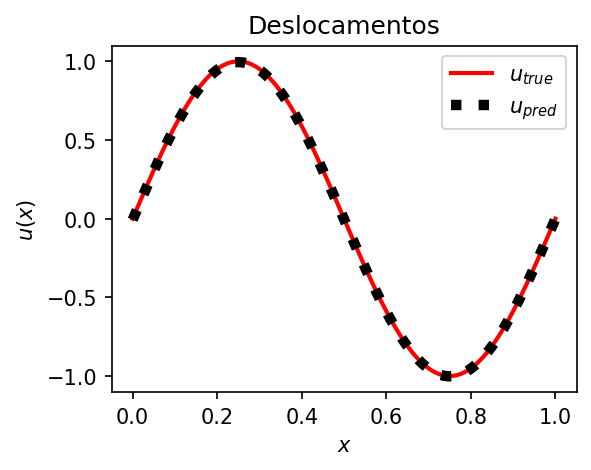

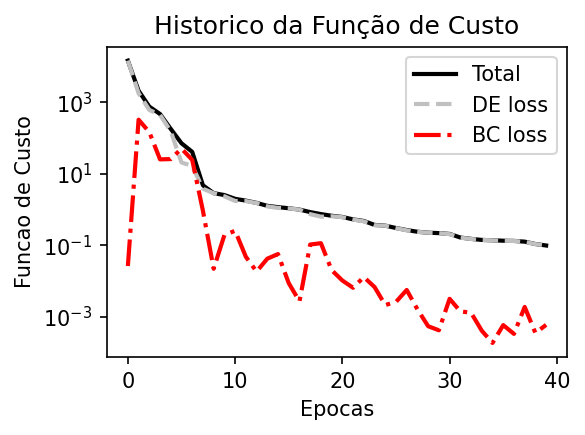

In [10]:
# Test data
samples = 100
x_test = generate_grid_1d(L, samples)
u_test = pinnModel.get_displacements(x_test)

# Solução Analitica
u_analytic = lambda x: np.sin(2 * np.pi * x / L)

# Plot displacements
plot_displacements_bar(x_test, u_test, u_analytic)

# Plot training history
pinnModel.plot_training_history()

In [ ]:
# filename = "displacements_bar_pinn"
# plt.savefig(filename + ".eps")
# plt.savefig(filename + ".png")

# filename = "training_history_bar_pinn"
# plt.savefig(filename + ".eps")
# plt.savefig(filename + ".png")